In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings("ignore", message=".*defaulting to pandas implementation.*")
pd.set_option('display.float_format', '{:.6f}'.format)

# Import Model

In [2]:
jupyter_dir = os.path.abspath(str(Path()))
jupyter_dir

'E:\\git\\machine-learning-option-pricing'

In [3]:
models_path = os.path.join(jupyter_dir,'trained_models','trained_models')
models = os.listdir(models_path)
for i, path in enumerate(models):
    print(f"{i}   {path}")

0   2024_10_09 23-01-12 Deep Neural Network otm
1   2024_10_09 23-11-23 Deep Neural Network
2   2024_10_10 11-56-07 Deep Neural Network
3   2024_10_10 12-04-22 Deep Neural Network
4   2024_10_11 10-19-52 Deep Neural Network
5   2024_10_11 11-25-11 Deep Neural Network
6   2024_10_11 12-08-00 Deep Neural Network
7   2024_10_11 12-45-52 Deep Neural Network
8   2024_10_11 17-10-51 Deep Neural Network


In [4]:
model = models[6]
model

'2024_10_11 12-08-00 Deep Neural Network'

In [5]:
model_path = os.path.join(models_path,model)

In [6]:
model_files = os.listdir(model_path)
model_files

['2024_10_11 12-08-00 Deep Neural Network insample.csv',
 '2024_10_11 12-08-00 Deep Neural Network outsample.csv',
 '2024_10_11 12-08-00 Deep Neural Network.pkl',
 '2024_10_11 12-08-00 Deep Neural Network.txt']

In [7]:
spec_path = os.path.join(model_path,[file for file in model_files if file.endswith('.txt')][0])

In [8]:
import joblib

In [9]:
model_fit = joblib.load(os.path.join(model_path,[file for file in model_files if file.endswith('.pkl')][0]))

In [10]:
with open(spec_path, "r") as specs:
    for line in specs:
        print(line.strip())

Fri Oct 11 11:51:23 2024
spot(s):
[ 676.03  682.43  683.09  696.44  701.13  712.8   718.09  720.76  735.18
743.63  750.18  752.69  753.6   755.88  764.87  770.19  772.72  777.66
778.97  783.62  788.25  789.34  793.89  805.28  825.26  826.08  826.55
827.3   827.32  831.68  832.16  833.74  835.12  836.44  838.11  840.13
842.82  843.98  845.19  845.22  845.62  845.68  849.36  849.62  849.89
857.33  863.39  865.    868.15  868.97  869.08  869.78  870.18  870.82
871.38  871.64  871.84  872.49  873.75  873.87  876.65  879.73  885.33
887.22  888.94  890.17  890.47  895.24  898.8   899.16  903.41  904.15
906.79  908.76  909.78  911.39  913.19  919.06  927.54  930.68  931.03
934.45  952.69  966.34  969.87  985.17 1005.42 1156.65 1161.63 1165.72
1187.4  1188.42 1195.66 1203.3  1207.56 1210.16 1213.76 1214.59 1214.91
1225.07 1228.34 1231.72 1235.03 1236.81 1240.01 1242.38 1244.81 1245.64
1248.97 1249.51 1251.98 1252.02 1253.1  1253.33 1253.75 1257.85 1259.82
1260.39 1260.44 1260.47 1261.75 1263.0

In [11]:
model_files

['2024_10_11 12-08-00 Deep Neural Network insample.csv',
 '2024_10_11 12-08-00 Deep Neural Network outsample.csv',
 '2024_10_11 12-08-00 Deep Neural Network.pkl',
 '2024_10_11 12-08-00 Deep Neural Network.txt']

In [12]:
pd.reset_option("display.max_rows")
pd.reset_option("display.max_columns")
outsample_path = os.path.join(model_path,[file for file in model_files if file.find('outsample') != -1][0])
outsample = pd.read_csv(outsample_path).iloc[:,1:]

# Test Model

In [13]:
maturities = outsample['days_to_maturity'].unique().tolist()
barrier_type_names = outsample['barrier_type_name'].unique().tolist()
ws = outsample['w'].unique().tolist()
print(f"\nmaturities:\n     maturities = {maturities}")
print(f"\ntypes:\n     barrier_type_names = {barrier_type_names}\n     ws = {ws}\n")


maturities:
     maturities = [60, 90, 180, 360, 540, 720]

types:
     barrier_type_names = ['DownOut', 'DownIn', 'UpOut', 'UpIn']
     ws = ['put', 'call']



In [14]:
by_wbt = outsample.copy().set_index(['w','barrier_type_name','days_to_maturity']).sort_index()

In [15]:
RMSE = pd.DataFrame(
    np.zeros((len(maturities),len(barrier_type_names)),dtype=float),
    columns = barrier_type_names,
    index = maturities
)

for t in maturities:
    for b in barrier_type_names:
        RMSE.loc[t,b] = np.sqrt(np.average((by_wbt.loc[(slice(None), b, t),'outofsample_error'])**2))
print(f"\nRMSE:\n{RMSE}")


RMSE:
     DownOut   DownIn    UpOut      UpIn
60  4.960526 4.650438 5.848422  4.463147
90  3.787120 3.131083 5.026989  3.571056
180 3.129241 5.423969 3.660468  5.142797
360 4.597839 9.567281 3.681949  9.350123
540 6.766739 8.531116 3.759798  9.180917
720 9.906328 8.620879 4.326447 11.040372


In [16]:
MAE = pd.DataFrame(
    np.zeros((len(maturities),len(barrier_type_names)),dtype=float),
    index = maturities,
    columns = barrier_type_names
)
for t in maturities:
    for b in barrier_type_names:
        MAE.loc[t,b] = np.average(np.abs(by_wbt.loc[(slice(None), b, t),'outofsample_error']))
print(f"\nMAE:\n{MAE}")


MAE:
     DownOut   DownIn    UpOut     UpIn
60  4.024628 3.446673 4.283389 3.674671
90  2.857525 2.270267 4.040544 2.976784
180 2.372506 3.755593 2.831186 3.931586
360 3.592313 7.257451 3.061325 7.724549
540 5.032924 6.728299 3.020754 7.538521
720 7.503665 6.687021 3.364891 8.392199


In [17]:
errors_bypayoff = {}
for w in ws:
    errors = {}
    print(
        f"\n         {'#'*(len(w)+5)}"
        f"\n         # {w}s #"
        f"\n         {'#'*(len(w)+5)}"
    )
    RMSE = pd.DataFrame(
        np.zeros((len(maturities),len(barrier_type_names)),dtype=float),
        columns = barrier_type_names
        )
    RMSE[w] = maturities
    RMSE = RMSE.set_index(w,drop=True)
    for t in maturities:
        for b in barrier_type_names:
            RMSE.loc[t,b] = np.sqrt(np.average((by_wbt.loc[(w, b, t),'outofsample_error'])**2))
    print(f"RMSE:\n{RMSE}")
    print()
    errors['RMSE'] = RMSE
    


    MAE = pd.DataFrame(
        np.zeros((len(maturities),len(barrier_type_names)),dtype=float),
        columns = barrier_type_names
    )
    MAE[w] = maturities
    MAE = MAE.set_index(w,drop=True)
    for t in maturities:
        for b in barrier_type_names:
            MAE.loc[t,b] = np.average(np.abs(by_wbt.loc[(w, b, t),'outofsample_error']))
    print(f"MAE:\n{MAE}")
    print()
    errors['MAE'] = MAE
    errors_bypayoff[w] = errors


         ########
         # puts #
         ########
RMSE:
     DownOut    DownIn    UpOut     UpIn
put                                     
60  5.585910  5.954061 3.507855 4.277557
90  4.318776  3.810968 3.324454 3.514703
180 3.270095  6.669941 3.020630 3.438688
360 3.307347 12.194859 4.243189 7.114255
540 3.225187 10.519985 4.136726 6.231160
720 4.622958  9.834858 5.111803 5.417544

MAE:
     DownOut    DownIn    UpOut     UpIn
put                                     
60  4.760830  5.045465 3.006207 3.810838
90  3.446488  3.059214 2.743002 3.044640
180 2.341929  5.396281 2.508201 2.565494
360 2.609040 10.744649 3.571750 5.444824
540 2.478831  9.261918 3.283845 4.698762
720 3.860057  8.041292 4.249728 3.932091


         #########
         # calls #
         #########
RMSE:
       DownOut   DownIn    UpOut      UpIn
call                                      
60    4.314862 2.524251 7.636877  4.640685
90    3.229429 2.196209 6.397648  3.626567
180   2.995614 3.786162 4.255230  6.4087

In [18]:
max_MAE = max(errors['MAE'].values.flatten())
max_RMSE = max(errors['RMSE'].values.flatten())
plot_height = max(max_RMSE,max_MAE)*1.05
maturities = errors['MAE'].index.astype(str).tolist()

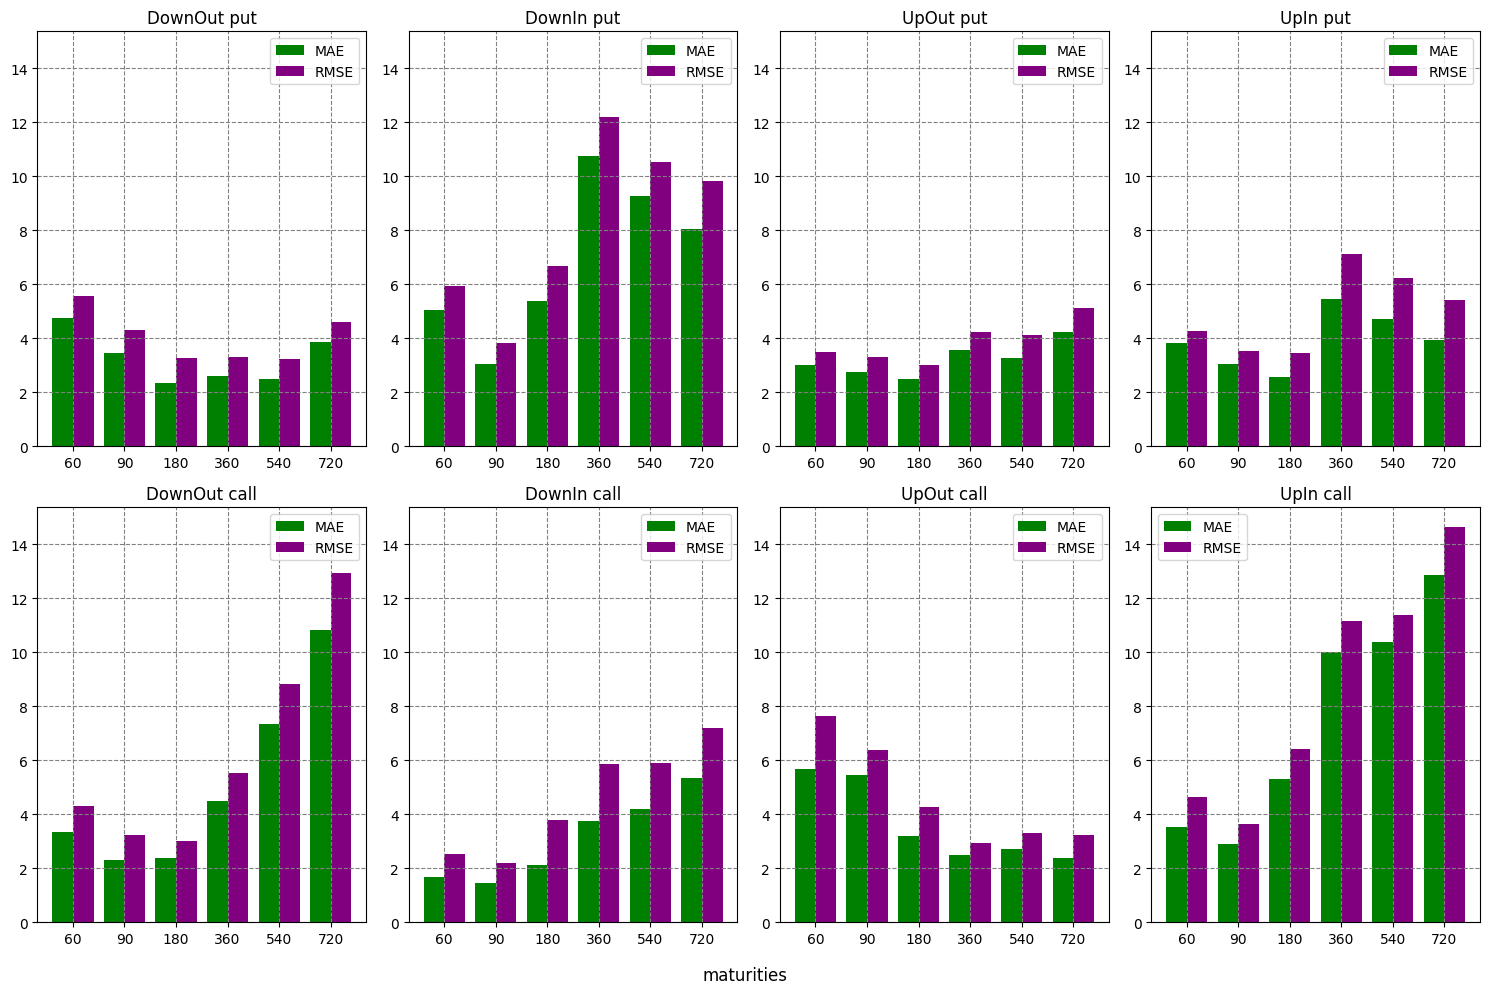

In [19]:
fig, axs = plt.subplots(2, 4, figsize=(15,10))
bar_width = 0.4
i = 0
for w, errors in errors_bypayoff.items():
    for b in barrier_type_names:

        MAE = errors['MAE'][b]
        RMSE = errors['RMSE'][b]
        x_positions = range(len(maturities))
        axs[i // 4, i % 4].grid(True,which='both', linestyle='--', color='gray')
        axs[i // 4, i % 4].bar(
            [x - 0.5 * bar_width for x in x_positions], MAE, width=bar_width, color='green',label="MAE"
        )
        
        axs[i // 4, i % 4].bar(
            [x + 0.5 * bar_width for x in x_positions], RMSE, width=bar_width, color='purple', label="RMSE"
        )
        axs[i // 4, i % 4].set_title(f'{b} {w}')
        axs[i // 4, i % 4].set_xticks(x_positions)
        axs[i // 4, i % 4].set_xticklabels(maturities)
        axs[i // 4, i % 4].set_ylim(0, plot_height)
        axs[i // 4, i % 4].legend()
        i += 1

fig.supxlabel('maturities')

plt.tight_layout()
plt.show()

In [20]:
by_wbt.loc[('put','DownIn',slice(None)),:].describe()

,spot_price,strike_price,barrier,barrier_price,rebate,dividend_rate,risk_free_rate,theta,kappa,rho,eta,v0,moneyness,observed_price,outofsample_target,outofsample_prediction,outofsample_error
count,137533.000000,137533.000000,137533.000000,137533.000000,137533.000000,137533.000000,137533.000000,137533.000000,137533.000000,137533.000000,137533.000000,137533.000000,137533.000000,137533.000000,137533.000000,137533.000000,137533.000000
mean,894.101051,894.375916,666.875459,59.874514,0.000000,0.025719,0.040000,0.100387,5.559839,-0.996185,0.203622,0.081902,-0.633215,59.877582,59.877582,55.011348,-4.866234
std,48.104179,71.444101,159.070548,48.331249,0.000000,0.001760,0.000000,0.024541,1.122413,0.012208,0.026176,0.035970,0.274248,48.327593,48.327593,45.581513,7.180290
min,768.060000,691.254000,384.030000,0.000036,0.000000,0.023007,0.040000,0.070609,2.052795,-1.000000,0.154510,0.034322,-0.944710,0.000000,0.000000,-9.981632,-31.409614
25%,857.610000,843.234122,538.487400,13.622373,0.000000,0.024448,0.040000,0.082108,4.903679,-1.000000,0.186537,0.055244,-0.898893,13.614872,13.614872,14.535805,-10.016156
50%,900.910000,893.003816,671.177950,53.536743,0.000000,0.025182,0.040000,0.087693,5.515430,-0.999987,0.199267,0.070632,-0.656918,53.532260,53.532260,49.784311,-4.496711
75%,927.170000,946.378898,798.950150,96.390932,0.000000,0.026893,0.040000,0.123218,5.972676,-0.999946,0.221772,0.107652,-0.394376,96.383349,96.383349,88.517807,0.056697
max,986.540000,1085.194000,976.674600,203.457350,0.000000,0.030652,0.040000,0.151191,8.797120,-0.925566,0.269855,0.174318,0.041585,203.528541,203.528541,198.834049,17.947766


In [21]:
by_wbt.loc[('call','DownIn',slice(None)),:].describe()

,spot_price,strike_price,barrier,barrier_price,rebate,dividend_rate,risk_free_rate,theta,kappa,rho,eta,v0,moneyness,observed_price,outofsample_target,outofsample_prediction,outofsample_error
count,134191.000000,134191.000000,134191.000000,134191.000000,134191.000000,134191.000000,134191.000000,134191.000000,134191.000000,134191.000000,134191.000000,134191.000000,134191.000000,134191.000000,134191.000000,134191.000000,134191.000000
mean,893.540976,891.412209,669.549847,24.605655,0.000000,0.025739,0.040000,0.100683,5.560258,-0.996256,0.203899,0.082342,4.615232,24.621374,24.621374,22.348504,-2.272870
std,48.199152,70.062035,159.309802,41.824750,0.000000,0.001766,0.000000,0.024625,1.127315,0.012101,0.026225,0.036091,4.855076,41.815736,41.815736,38.868676,4.450602
min,768.060000,691.254000,384.030000,0.000005,0.000000,0.023007,0.040000,0.070609,2.052795,-1.000000,0.154510,0.034322,-0.039925,0.000000,0.000000,-3.222079,-27.810433
25%,857.610000,841.857980,538.954275,0.056455,0.000000,0.024448,0.040000,0.082108,4.903679,-1.000000,0.186537,0.055244,0.638627,0.108561,0.108561,-0.009676,-4.085776
50%,900.910000,890.142735,675.469150,1.374953,0.000000,0.025182,0.040000,0.087693,5.515430,-0.999987,0.199267,0.070632,1.766823,1.382650,1.382650,1.474511,-0.589578
75%,927.170000,941.987061,801.448550,32.279858,0.000000,0.026893,0.040000,0.123218,5.984261,-0.999946,0.221772,0.107652,8.652343,32.294808,32.294808,26.957516,0.213245
max,986.540000,1085.194000,976.674600,201.466468,0.000000,0.030652,0.040000,0.151191,8.797120,-0.925566,0.269855,0.174318,17.086567,201.237422,201.237422,191.125626,9.911752


In [22]:
types  = ['DownOut', 'DownIn', 'UpOut', 'UpIn']

In [23]:
for b in types:
    print(f"\n{b}")
    print(by_wbt.loc[('call',b,slice(None)),:].shape[0])


DownOut
138000

DownIn
134191

UpOut
125304

UpIn
137140


In [24]:
types  = ['DownOut', 'DownIn', 'UpOut', 'UpIn']
for b in types:
    print(f"\n{b}")
    print(by_wbt.loc[('put',b,slice(None)),:].shape[0])


DownOut
125304

DownIn
137533

UpOut
138000

UpIn
137073


In [25]:
outsample.loc[:,'security_type'] = outsample['w'] + outsample['barrier_type_name']

In [41]:
down_calls = outsample.copy()[
    (
        (outsample['w'] == 'call')
        &
        (outsample['updown'] =='Down')
    )
]
observed_price = np.sum(down_calls['barrier_price'])
outofsample_prediction = np.sum(down_calls['outofsample_prediction'])
print(f"\n{observed_price}\n{outofsample_prediction}\n")
RMSE = float(np.sqrt(np.mean(np.array(down_calls['outofsample_prediction']-down_calls['barrier_price'])**2)))
print(RMSE)
MAE = float(np.average(np.abs(np.array(down_calls['outofsample_prediction']-down_calls['barrier_price']))))
MAE


13589499.827393925
13031764.64057841

6.23247307446231


4.138054538215969

In [46]:
down_puts = outsample.copy()[
    (
        (outsample['w'] == 'put')
        &
        (outsample['updown'] =='Down')
    )
]
observed_price = np.sum(down_puts['barrier_price'])
outofsample_prediction = np.sum(down_puts['outofsample_prediction'])
print(f"\n{observed_price}\n{outofsample_prediction}\n")
RMSE = float(np.sqrt(np.mean(np.array(down_puts['outofsample_prediction']-down_puts['barrier_price'])**2)))
print(RMSE)
MAE = float(np.average(np.abs(np.array(down_puts['outofsample_prediction']-down_puts['barrier_price']))))
MAE


12072448.651386563
11597451.068245381

6.894238521267653


5.17226749129941

In [47]:
up_calls = outsample.copy()[
    (
        (outsample['w'] == 'call')
        &
        (outsample['updown'] =='Up')
    )
]
observed_price = np.sum(up_calls['barrier_price'])
outofsample_prediction = np.sum(up_calls['outofsample_prediction'])
print(f"\n{observed_price}\n{outofsample_prediction}\n")
RMSE = float(np.sqrt(np.mean(np.array(up_calls['outofsample_prediction']-up_calls['barrier_price'])**2)))
print(RMSE)
MAE = float(np.average(np.abs(np.array(up_calls['outofsample_prediction']-up_calls['barrier_price']))))
MAE


13589481.516693657
12591204.992927382

7.702275770830765


5.676125319075396

In [48]:
up_puts = outsample.copy()[
    (
        (outsample['w'] == 'put')
        &
        (outsample['updown'] =='Up')
    )
]
observed_price = np.sum(up_puts['barrier_price'])
outofsample_prediction = np.sum(up_puts['outofsample_prediction'])
print(f"\n{observed_price}\n{outofsample_prediction}\n")
RMSE = float(np.sqrt(np.mean(np.array(up_puts['outofsample_prediction']-up_puts['barrier_price'])**2)))
print(RMSE)
MAE = float(np.average(np.abs(np.array(up_puts['outofsample_prediction']-up_puts['barrier_price']))))
MAE


12072448.289400697
11514694.672443535

4.60507989917697


3.563197772803405